In [1]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq
import pandas as pd
import scvi

%load_ext autoreload
%autoreload 2

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp6g8dz7lf
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp6g8dz7lf/_remote_module_non_scriptable.py
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_trai

In this tutorial, we demonstrate how to analyse single cell level nanostring smi data. We used replicate 12 to demonstrate here instead of 5-3 in our paper. We transferred our data from the Giotto object located here https://nanostring.com/products/cosmx-spatial-molecular-imager/nsclc-ffpe-dataset

In [2]:
adata = sc.read_h5ad("../../../../spatialLDA/spatiallda/reproducibility/figure2/data/Lung12.h5ad")
adata.var_names_make_unique()

In [3]:
adata.obsm['spatial'] = adata.obsm['spatial_raw']

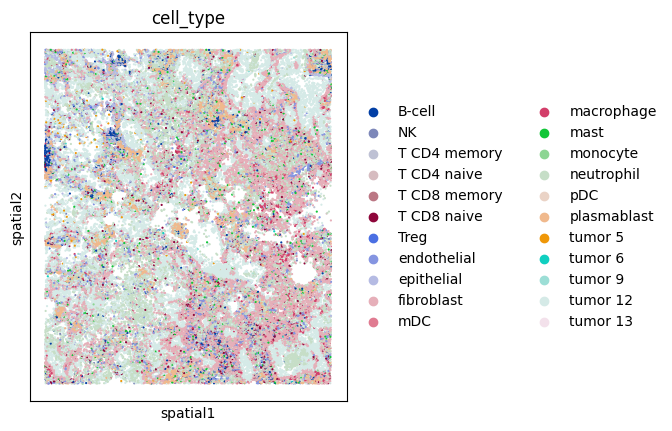

In [4]:
sc.pl.spatial(adata, spot_size = 0.03, color = 'cell_type')

In [5]:
sc.pp.filter_cells(adata, min_genes=30)
sctm.pp.filter_genes(adata, 0.01,  expression_cutoff_99q = 0)
sc.pp.highly_variable_genes(adata, n_top_genes=600, flavor="seurat_v3")

In [6]:
sq.gr.spatial_neighbors(adata)

In [7]:
n_topics = 15
# 
model = sctm.stamp.STAMP(
    adata[:, adata.var.highly_variable],
    n_topics = n_topics,
)

# uses gpu by default to use cpu use device="cpu"
model.train(learning_rate = 0.01)

Computing background frequencies


/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/torch_geometric/utils/sparse.py:216: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return adj.to_sparse_csc()
Loss:257.347:  10%|█         | 102/1000 [10:58<1:36:35,  6.45s/it]

Early Stopping


In [8]:
# Get topic prop which is the latent representation and beta which are the gene modules
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
# Add it into adata to visualize
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

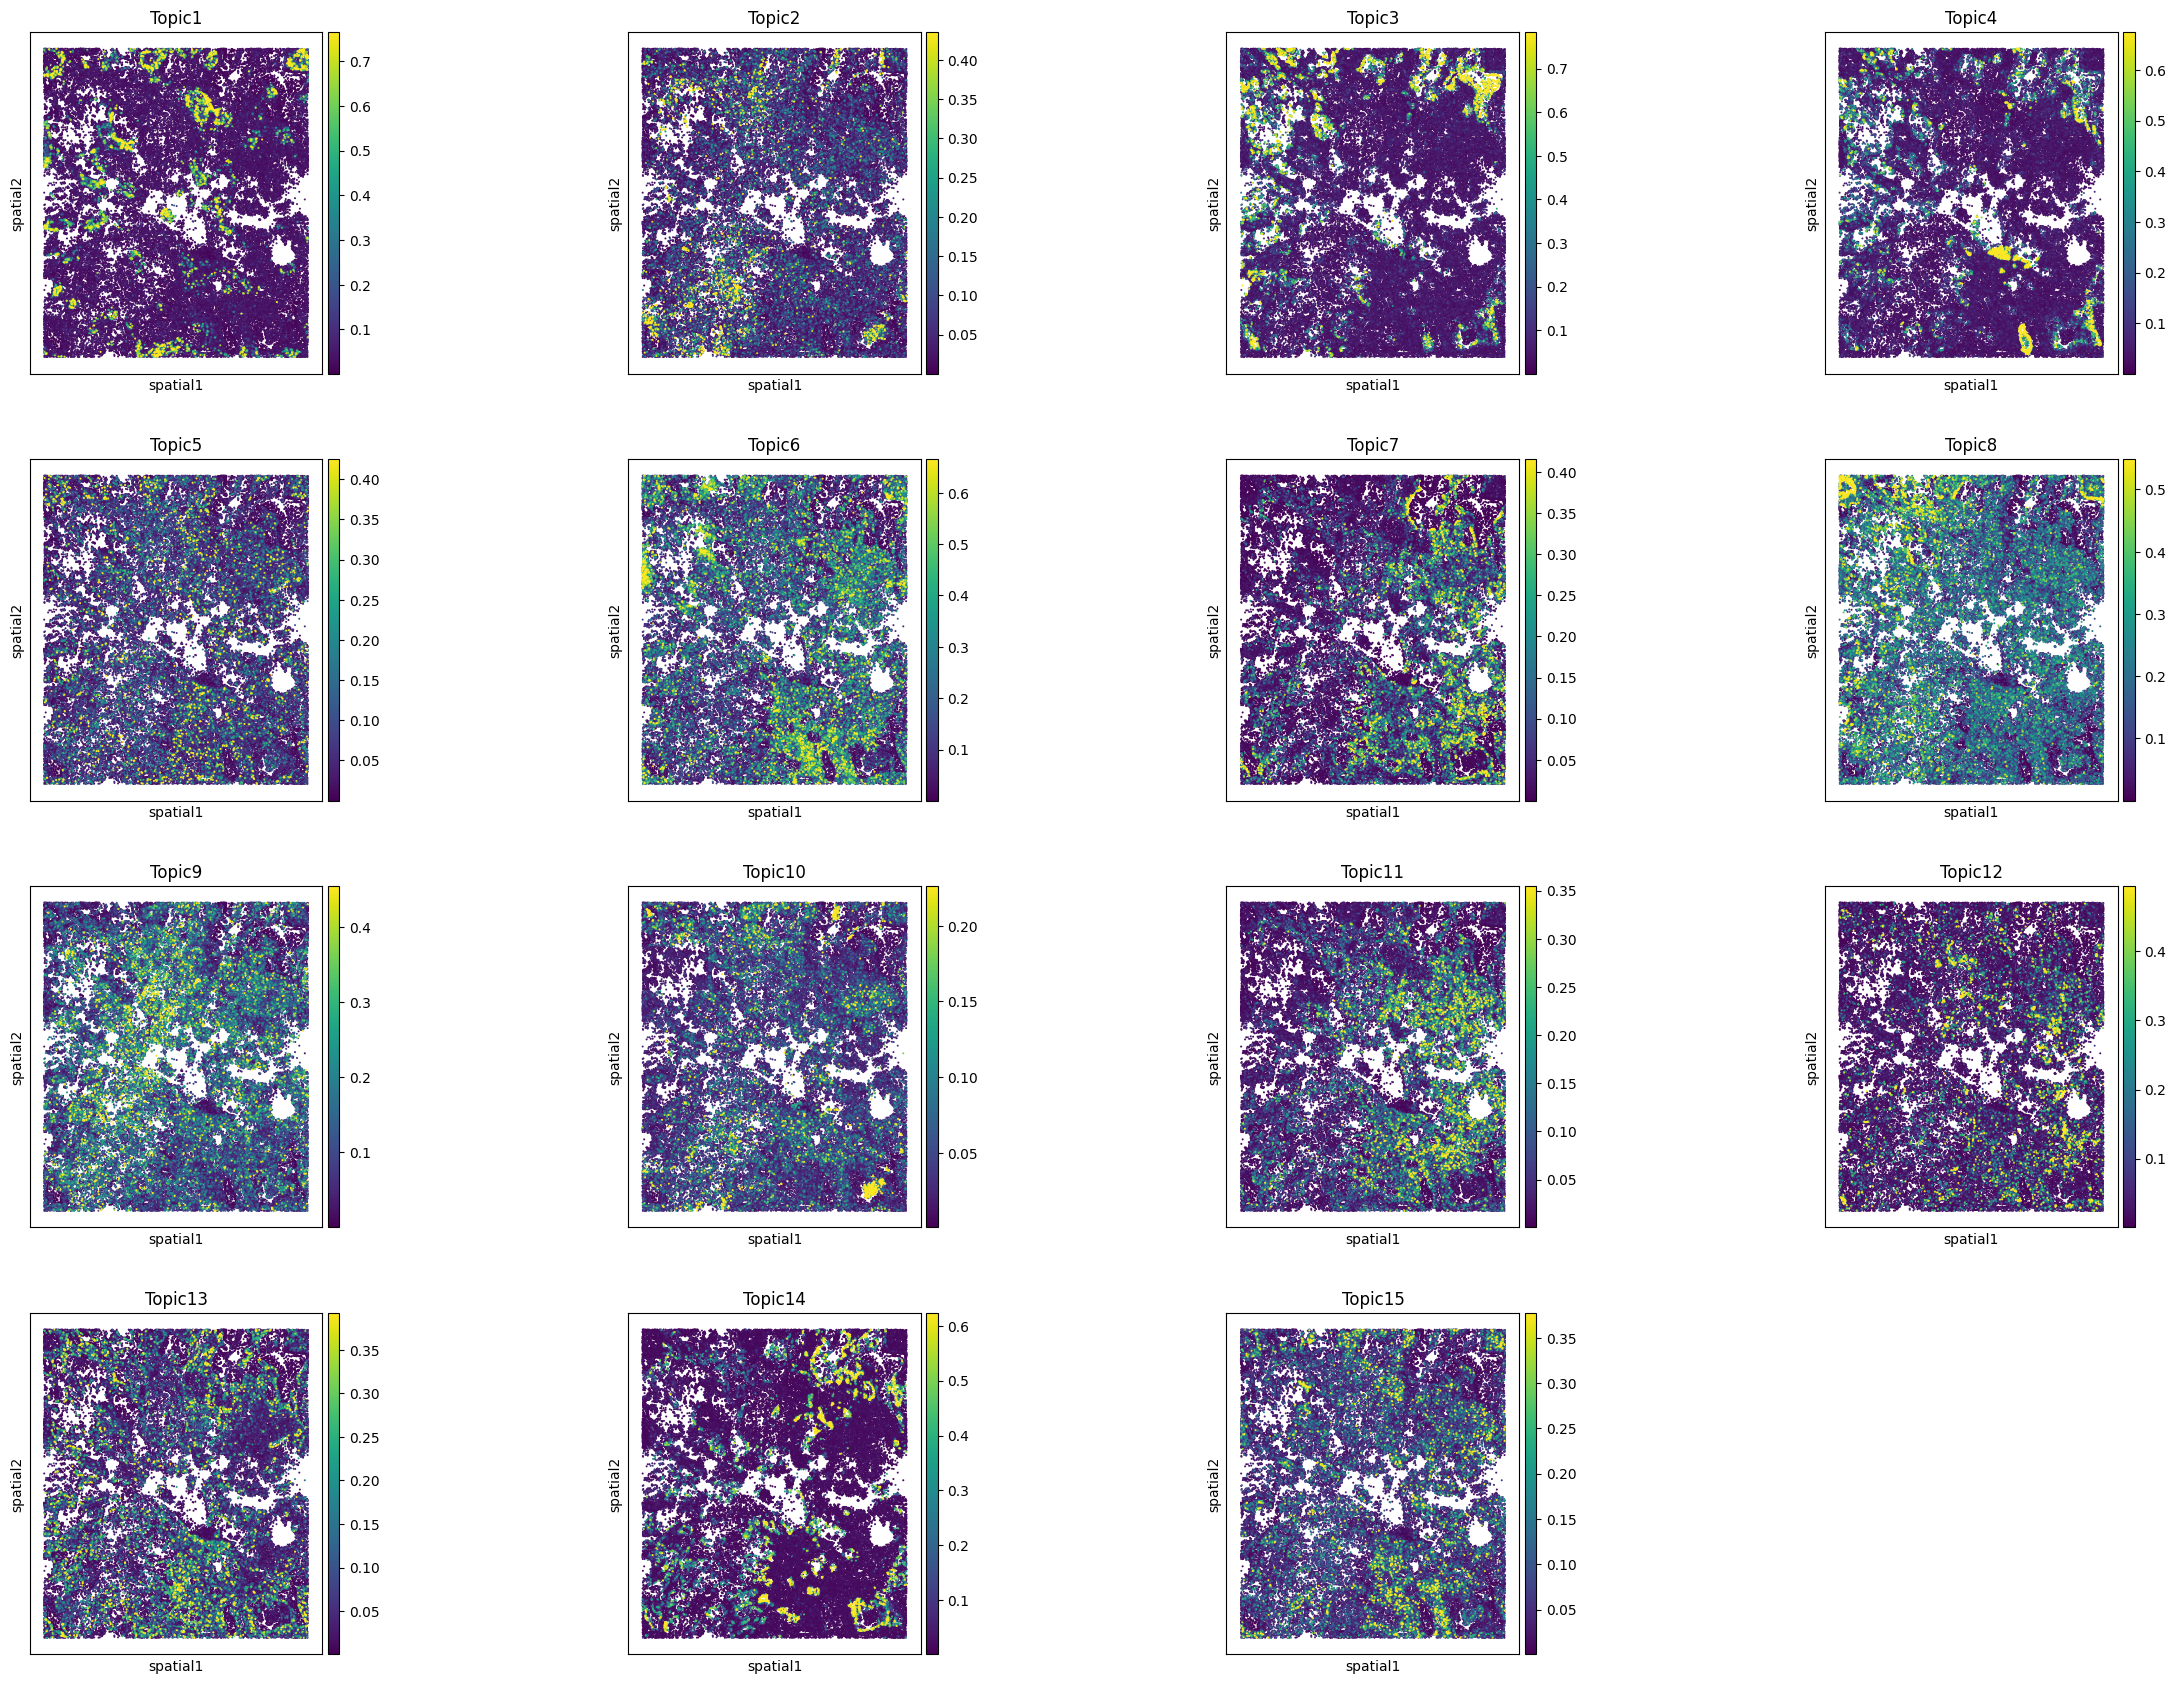

In [9]:
sc.pl.spatial(adata, color = topic_prop.columns, spot_size = 0.03, vmax = 'p99')

Here we used the disco function which calls discotoolkit_py to do enrichment analysis.

The website for DISCO can be found here https://immunesinglecell.org/, where over 60 million cells are processed and built into atlases.

In [10]:
celltypes = sctm.analysis.get_topic_disco(beta)

INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend Sequentia

In [11]:
filtered = [] 
for i in celltypes.keys():
    # Filter out the low overlap
    df = celltypes[i].loc[celltypes[i].overlap > 5]
    # Filter only in lung
    df = df.loc['name'].str.contains("lung")
    df["Topic"] = i
    filtered.append(df.head(2))

In [12]:
filtered = pd.concat(filtered)
filtered

pval       or                                               name   
30     0.0  145.105               Plasma cell vs All others in bladder  \
5      0.0  135.393               Plasma cell vs All others in adipose   
41     0.0  259.795            Monocyte vs All others in adrenal_gland   
487    0.0  228.482                Granulocyte vs All others in tonsil   
1218   0.0   90.958            Goblet cell vs Paneth cell in intestine   
961    0.0   71.426           Monocyte vs Cycling macrophage in testis   
336    0.0  116.705             Paneth cell vs All others in intestine   
553    0.0   53.880    PDAC specific ductal cell vs All others in PDAC   
168    0.0   91.244                Capillary EC vs All others in ovary   
254    0.0   53.273    Fetal MHC- capillary EC vs All others in testis   
392    0.0  151.377  Light zone GC B cell vs Dark zone GC B cell in...   
484    0.0  113.298  GZMK+IL7R- CD8 T cell vs GZMK+IL7R+ CD8 T cell...   
66     0.0  141.015            Fibroblast vs All others in bone_marrow   
674    0.0  134.508  Sertoli and Interstitial cell common progenito...   
7      0.0   72.905  S phase CXCL5+ADAM12+ fibroblast vs S phase MF...   
318    0.0   50.140           Goblet cell vs Airway basal cell in lung   
69     0.0   13.657          TFF+ cholangiocyte vs All others in liver   
360    0.0   61.439       CCL19+APOE+ fibroblast vs All others in PDAC   
346    0.0   54.855     BNC2+ZFPM2+ fibroblast vs Lymphatic EC in PDAC   
607    0.0  385.666                   Macrophage vs All others in skin   
545    0.0  313.052                   Macrophage vs All others in PDAC   
461    0.0  131.444            SPRR2F+ pericyte vs All others in ovary   
714    0.0  102.615                   Pericyte vs All others in thymus   
160    0.0   47.771  APOD+PTGDS+ fibroblast vs CXCL5+ADAM12+ fibrob...   
106    0.0   46.498  Secretoglobin mammary luminal progenitor vs Al...   
674    0.0  153.335                     T cell vs All others in testis   
305    0.0  139.419                        T cell vs All others in eye   

                                                   gene background overlap   
30    IGKC,CD38,JCHAIN,MZB1,IGHG2,IGHG1,TNFRSF17,CD7...       6448      11  \
5     IGKC,JCHAIN,MZB1,IGHG2,IGHA1,IGHG1,IGHM,TNFRSF...       8484      11   
41    S100A8,FGR,IL1B,CSF3R,CXCL8,HCK,BST1,IL1RN,CCL...       4276      13   
487   CXCR1,CXCL8,HCAR2,CSF3R,S100A8,IL1RN,IL1B,OLR1...       7683      18   
1218  S100A6,LGALS3,AGR2,GSN,ANXA2,CLDN4,KRT19,FOS,M...      11184      17   
961            S100A6,LGALS3,PLAC8,CD55,S100P,ANXA2,FOS      13055       7   
336     LYZ,SERPINA1,LCN2,OLFM4,PIGR,SOX9,AGR2,LGALS3BP      11184       8   
553   S100A6,PIGR,SLC40A1,AGR2,LCN2,KRT8,MMP7,CXCL5,...       9711      15   
168   KDR,RAMP3,IL3RA,ESAM,VWF,CDH5,RAMP2,PECAM1,PDG...      11275      13   
254   KDR,IL3RA,ESAM,VWF,CDH5,RAMP2,PECAM1,EFNB2,KIT...      13055      13   
392   CD37,HLA-DRA,CD74,HLA-DPA1,HLA-DPB1,MS4A1,HLA-...      11184       7   
484        CD74,HLA-DRB1,HLA-DRA,HLA-DPB1,HLA-DPA1,RGS1       9455       6   
66    VCAM1,COL11A1,COL3A1,FN1,COL6A3,COL8A1,PDGFRA,...       8569      17   
674   COL1A1,COL3A1,COL1A2,CDH11,PDGFRA,COL6A2,COL6A...      13055      18   
7                      SAT1,CXCL3,PTGS2,CLU,CXCL2,CCL20       8484       6   
318        SCGB3A1,SLPI,CXCL17,CLU,LTF,CXCL2,MMP7,CXCL3       9264       8   
69                     ACE2,GC,IL20RA,TTR,HSD17B2,NR1H4       9455       6   
360   COL8A1,CDH11,COL11A1,PDGFRA,COL12A1,COL1A1,LUM...       9711      15   
346   COL8A1,COL11A1,COL1A1,MEG3,CDH11,COL12A1,CXCL1...       9711      10   
607   C1QA,C1QC,C1QB,FCER1G,MARCO,CD14,CD74,HLA-DRA,...       8928      20   
545   C1QA,C1QC,C1QB,FCER1G,CD14,CD74,HLA-DRA,HLA-DR...       9711      19   
461   ACTA2,MYH11,RGS5,SPARCL1,MT2A,COL4A2,COL4A1,JA...      11275      16   
714   RGS5,ACTA2,COL4A1,COL4A2,MT2A,SPARCL1,MYH11,CO...       9218      16   
160          KRT17,S100A6,S100A2,TACSTD2,SLC2A1,S100A10      

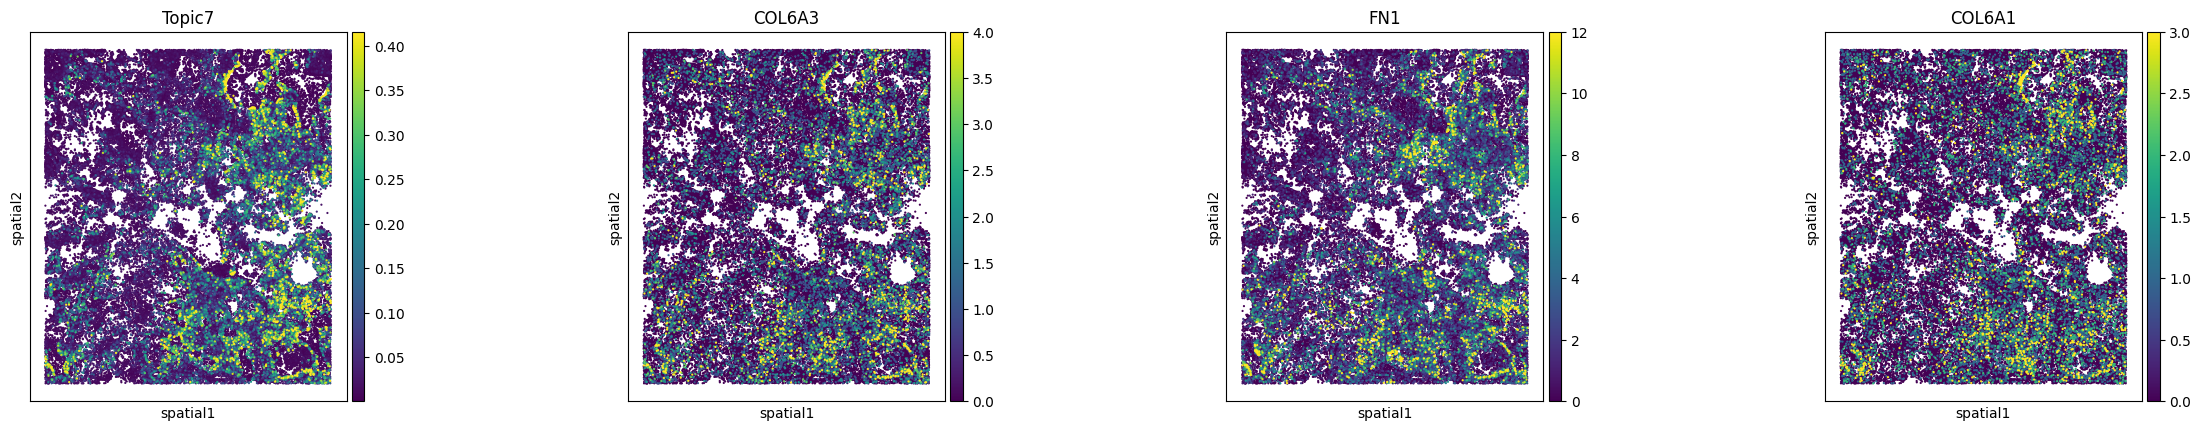

In [14]:
# Plot out myofibrolast and top genes "Topic7"
sc.pl.spatial(adata, color = ["Topic7"] + beta.nlargest(3, "Topic7").index.tolist(), spot_size = 0.03, vmax ='p99')